We will now train the basic model from #2 on a stratified fold we calculated in #3. This will give us a framework we will be able to leverage with some consistency to evaluate model performance (and the impact of various preprocessing techniques).

In [1]:
from fastai2.test import *
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from pathlib import Path
import pandas as pd
import numpy as np
import librosa

In [29]:
trn_df = pd.read_csv('data/train_with_splits.csv')
trn_df_idx = pd.read_csv('data/train.csv').set_index('fname') 

trn_paths = list(Path('data/audio_train_22k/').iterdir())
tst_paths = list(Path('data/audio_test_22k/').iterdir())

splits = pd.read_pickle('data/splits.pkl')

mean_std = 0.08

def open_audio_file(path):
    x, sr = librosa.core.load(path, sr=None)
    # grabbing first 2 seconds of audio and padding with 0s if too short
    return np.pad(x, (0, 22050*2), 'constant')[:22050*2].reshape(1, -1)

def item_to_label(path): return trn_df_idx.loc[path.name].label
tfms = [[open_audio_file], [item_to_label, Categorize()]]

@ToTensor
def encodes(self, o:np.ndarray): return TensorBase(o) / mean_std

item_audio_tfms = [ToTensor()]

In [13]:
trn_df.head()

,fname,label,manually_verified,train_0,val_0,train_1,val_1,train_2,val_2,train_3,val_3,train_4,val_4
0,00044347.wav,Hi-hat,0,True,False,False,True,True,False,True,False,True,False
1,001ca53d.wav,Saxophone,1,True,False,True,False,True,False,True,False,False,True
2,002d256b.wav,Trumpet,0,True,False,True,False,True,False,True,False,False,True
3,0033e230.wav,Glockenspiel,1,True,False,True,False,False,True,True,False,True,False
4,00353774.wav,Cello,1,False,True,True,False,True,False,True,False,True,False


In [34]:
trn_dir = 'data/audio_train_22k'
trn_paths = []

for fn in trn_df.fname: trn_paths.append(Path(f'{trn_dir}/{fn}'))

In [61]:
def get_databunch(split_num=0):
    dsrc = DataSource(trn_paths, tfms, splits=splits[split_num])

    batch_tfms = [Cuda()]
    return dsrc.databunch(after_item=item_audio_tfms, after_batch=batch_tfms, bs=128, num_workers=12)

In [60]:
dbch = get_databunch()

In [57]:
def get_learner():
    def conv_block(in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Conv1d(out_channels, out_channels, kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
        )


    def pool_and_dropout_block(pool_size):
        return nn.Sequential(
            nn.MaxPool1d(pool_size),
            nn.Dropout(0.1)
        )

    def fc_block(in_features, out_features):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.BatchNorm1d(out_features),
        )

    arch = nn.Sequential(
        conv_block(1, 16, 9),
        pool_and_dropout_block(16),
        conv_block(16, 32, 3),
        pool_and_dropout_block(4),
        conv_block(32, 64, 3),
        pool_and_dropout_block(4),
        conv_block(64, 128, 3),
        nn.AdaptiveAvgPool1d(1),
        Flatten(),
        fc_block(128, 128),
        fc_block(128, 128),
        nn.Linear(128, dbch.c)
    )

    def top_3_accuracy(preds, targs): return top_k_accuracy(preds, targs, 3)

    return Learner(
        dbch, arch, metrics=[accuracy, top_3_accuracy],
        opt_func=partial(Adam, wd=0.01, eps=1e-3)
    )

In [58]:
learn = get_learner()

In [45]:
learn.fit_one_cycle(30, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.381335,3.662681,0.097244,0.210088,00:15
1,2.994561,4.073878,0.112324,0.248050,00:12
2,2.647795,4.324604,0.156006,0.312012,00:11
3,2.401662,3.606237,0.223089,0.411856,00:10
4,2.238101,4.837749,0.175767,0.345294,00:10
5,2.102665,3.262381,0.265211,0.483099,00:10
6,1.955692,3.104926,0.320853,0.523661,00:10
7,1.859565,2.952468,0.348414,0.558502,00:10
8,1.726450,1.986180,0.478939,0.712949,00:10
9,1.624443,2.546743,0.397296,0.615185,00:10


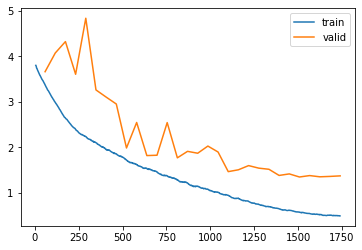

In [46]:
learn.recorder.plot_loss()

In [48]:
learn.save('simple')

In [54]:
def create_submission_and_submit(sub_name):
    preds = learn.get_preds(dl=test_dl(dbch, tst_paths))[0]
    predicted_label_idxs = preds.argsort(descending=True)[:, :3]
    
    fns, predicted_labels = [], []

    for path, idxs in zip(tst_paths, predicted_label_idxs):
        fns.append(path.name)
        predicted_labels.append([dbch.vocab[idx] for idx in idxs])
        
    sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
    sub.label = sub.label.apply(lambda lst: ' '.join(lst))
    sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)
    
    !kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

In [56]:
create_submission_and_submit('simple')

100%|██████████████████████████████████████| 89.4k/89.4k [00:03<00:00, 24.3kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge

This submission would achieve a private score of ~0.73 which would be around place 450 on the LB.

Just to satisfy our curiosity (and also because this is a useful reference point to have), let's quickly see how averaging predictions from models trained on 5 folds would perform.

In [83]:
preds = []

for split_idx in range(5):
    dbch = get_databunch(split_idx)
    learn = get_learner()
    learn.fit_one_cycle(30, 3e-3)
    preds.append(learn.get_preds(dl=test_dl(dbch, tst_paths))[0])

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.356473,3.296989,0.159646,0.299012,00:13
1,2.971727,3.181380,0.197608,0.377015,00:11
2,2.624015,3.151413,0.247010,0.452938,00:10
3,2.370402,2.830801,0.255330,0.489340,00:11
4,2.174860,3.064820,0.307852,0.512740,00:10
5,2.038840,2.472982,0.378055,0.593864,00:10
6,1.924747,2.332152,0.374415,0.606344,00:11
7,1.796241,2.557599,0.361414,0.614665,00:11
8,1.714515,2.543135,0.381695,0.610504,00:10
9,1.617271,2.662597,0.394176,0.612585,00:10


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.356256,3.487115,0.120942,0.236649,00:13
1,2.984857,3.466686,0.164921,0.304712,00:11
2,2.646941,2.867551,0.242932,0.451832,00:10
3,2.394777,2.887152,0.253927,0.463874,00:11
4,2.209690,4.334038,0.185864,0.341885,00:10
5,2.089832,2.343291,0.360209,0.610995,00:10
6,1.983356,2.854988,0.349738,0.548691,00:10
7,1.859866,2.226921,0.387435,0.648168,00:11
8,1.744781,2.563079,0.348168,0.580105,00:10
9,1.632260,2.912763,0.374869,0.595812,00:11


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.299448,3.468006,0.099842,0.248811,00:13
1,2.915285,3.938310,0.140518,0.288959,00:11
2,2.593872,3.811792,0.189118,0.349709,00:10
3,2.335932,3.128815,0.277866,0.464871,00:10
4,2.164765,2.375900,0.385631,0.612784,00:10
5,2.035178,3.069261,0.312203,0.552562,00:10
6,1.902148,2.305305,0.410460,0.636556,00:10
7,1.815810,2.098834,0.447966,0.663497,00:10
8,1.704750,2.281080,0.452721,0.662969,00:10
9,1.598133,1.995798,0.470681,0.678288,00:10


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.370623,3.521115,0.113648,0.242698,00:13
1,2.996475,3.073957,0.198088,0.404142,00:11
2,2.661635,5.513062,0.144450,0.309081,00:10
3,2.393218,4.034730,0.187998,0.360595,00:11
4,2.192938,4.341996,0.190653,0.374934,00:10
5,2.024791,2.527176,0.348380,0.611790,00:10
6,1.920529,4.118663,0.218269,0.382900,00:10
7,1.796769,3.446679,0.300584,0.531067,00:10
8,1.676948,2.722134,0.347849,0.575677,00:10
9,1.573126,3.124118,0.294211,0.474243,00:10


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.377732,3.440398,0.130365,0.267167,00:13
1,2.977478,3.312405,0.171674,0.376609,00:11
2,2.651495,2.803143,0.259120,0.454399,00:11
3,2.401819,4.217164,0.181867,0.335300,00:11
4,2.218316,3.172154,0.232296,0.478004,00:11
5,2.051476,3.063353,0.346567,0.542382,00:11
6,1.943374,2.707829,0.284871,0.518777,00:10
7,1.815044,2.328272,0.364807,0.625000,00:11
8,1.690883,2.070119,0.467811,0.696888,00:11
9,1.617365,3.032261,0.269850,0.475858,00:11


In [84]:
sub_name = 'simple_mean_of_5_folds'

In [85]:
predicted_label_idxs = torch.stack(preds).mean(0).argsort(descending=True)[:, :3]
    
fns, predicted_labels = [], []

for path, idxs in zip(tst_paths, predicted_label_idxs):
    fns.append(path.name)
    predicted_labels.append([dbch.vocab[idx] for idx in idxs])

sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
sub.label = sub.label.apply(lambda lst: ' '.join(lst))
sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

!kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████████████████████████████████| 89.7k/89.7k [00:03<00:00, 27.6kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge

A submission based on predictions averaged from 5 folds achieves around `0.796` on the LB, which is a jump of nearly 120 places to a position around 330.

Same architecture and an over 25% drop in error rate!